In [1]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d tapakah68/supervisely-filtered-segmentation-person-dataset

Dataset URL: https://www.kaggle.com/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 4.30G/4.31G [03:55<00:00, 17.6MB/s]
100% 4.31G/4.31G [03:55<00:00, 19.6MB/s]


In [5]:
!unzip -q supervisely-filtered-segmentation-person-dataset.zip

from IPython.display import clear_output
clear_output()

In [7]:
image_directory = '/content/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/'
mask_directory = '/content/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks/'

In [8]:
SIZE = 256
image_dataset = []
mask_dataset = []

In [9]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [10]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [11]:
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

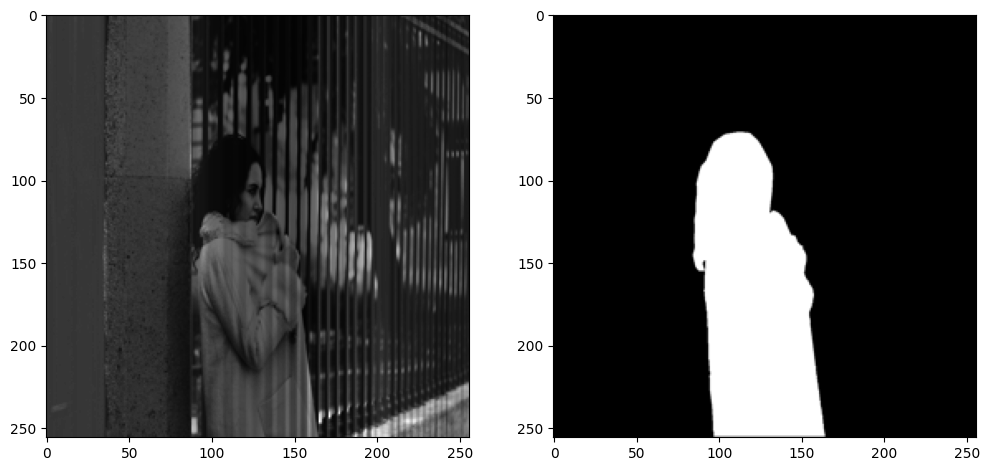

In [13]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [14]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [15]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [16]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [17]:
history = model.fit(X_train, y_train,
                    batch_size = 4,
                    verbose=1,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/10
600/600 [==============================] - 48s 53ms/step - loss: 0.5516 - accuracy: 0.7166 - val_loss: 0.4752 - val_accuracy: 0.7534
Epoch 2/10
600/600 [==============================] - 30s 49ms/step - loss: 0.4797 - accuracy: 0.7647 - val_loss: 0.4472 - val_accuracy: 0.7810
Epoch 3/10
600/600 [==============================] - 30s 51ms/step - loss: 0.4367 - accuracy: 0.7968 - val_loss: 0.3839 - val_accuracy: 0.8157
Epoch 4/10
600/600 [==============================] - 30s 50ms/step - loss: 0.3846 - accuracy: 0.8235 - val_loss: 0.3559 - val_accuracy: 0.8336
Epoch 5/10
600/600 [==============================] - 30s 50ms/step - loss: 0.3459 - accuracy: 0.8433 - val_loss: 0.3368 - val_accuracy: 0.8442
Epoch 6/10
600/600 [==============================] - 31s 51ms/step - loss: 0.3162 - accuracy: 0.8586 - val_loss: 0.3519 - val_accuracy: 0.8388
Epoch 7/10
600/600 [==============================] - 30s 51ms/step - loss: 0.2917 - accuracy: 0.8705 - val_loss: 0.3194 - val_accuracy:

In [18]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

9/9 [==============================] - 6s 291ms/step - loss: 0.3044 - accuracy: 0.8571
Accuracy =  85.70976257324219 %


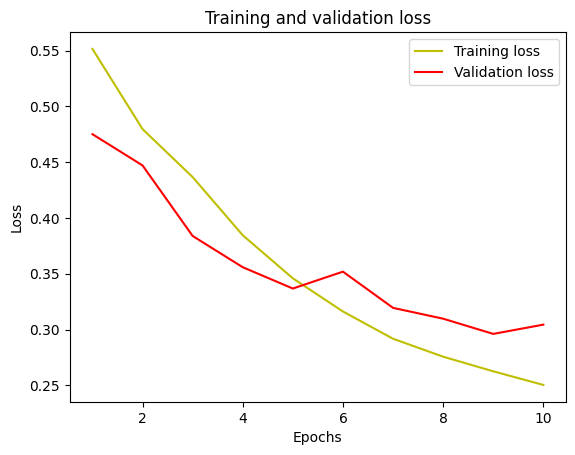

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

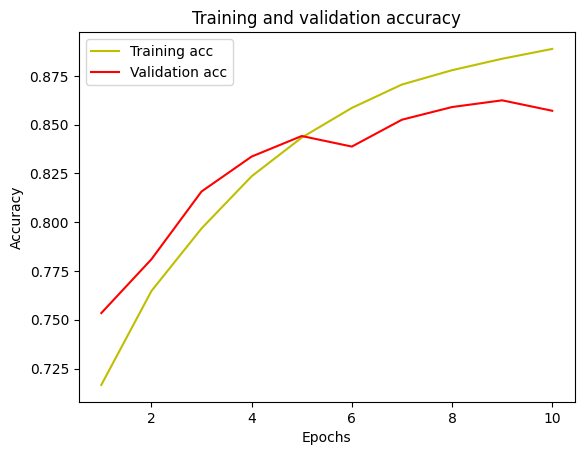

In [21]:
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

9/9 [==============================] - 1s 59ms/step


In [23]:
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6852211435610853


In [24]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

1/1 [==============================] - 1s 844ms/step


In [26]:
test_img_other = cv2.imread('/content/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds10_pexels-photo-687782.png', 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

In [27]:
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

1/1 [==============================] - 3s 3s/step


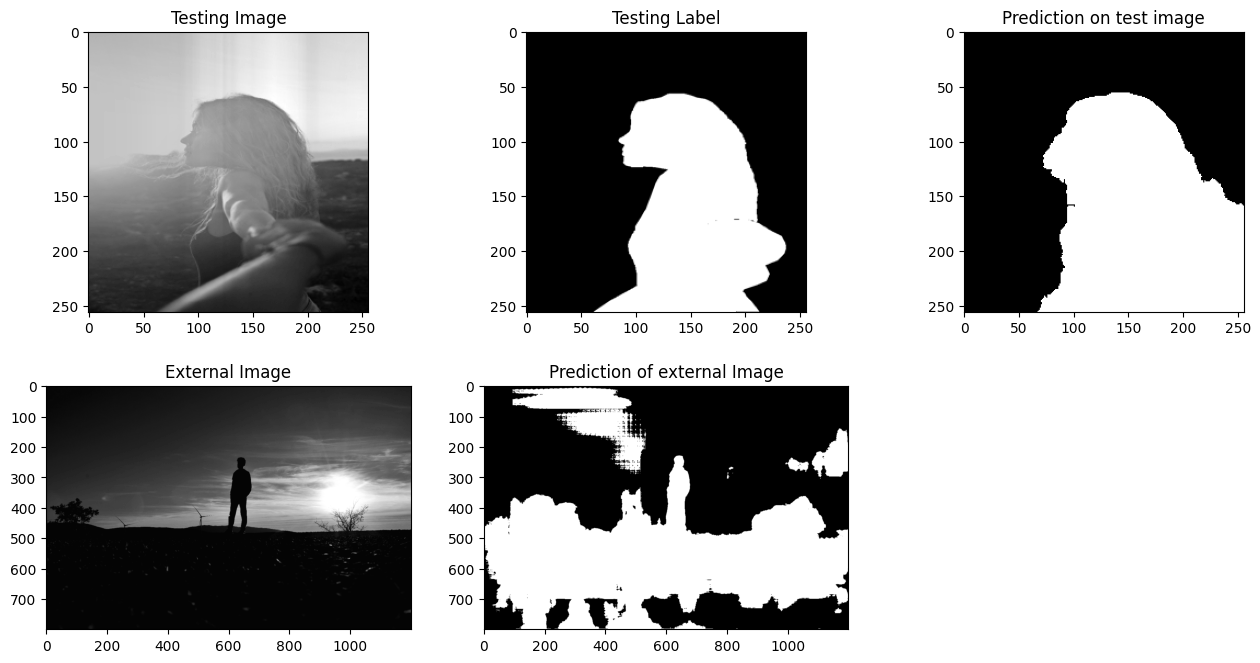

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()